# Deep Learning and Art : Neural Style Transfer
### Programatically painting an image following the style of another image using Neural Style Transfer algorithm

The idea is to use the filter responses from different layers of a convolutional network to build the style. Using filter responses from different layers (ranging from lower to higher) captures from low level details (strokes, points, corners) to high level details (patterns, objects, etc) which we will used to perturb the content image, which gives the final "painted" image.

Neural Style Transfer algorithm was created by Gatys et al. (2015) (https://arxiv.org/abs/1508.06576). 

Most of the D/L algorithms optimize a cost function to get a set of parameter values. In Neural Style Transfer, we optimize a cost function to get pixel values.

In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf

%matplotlib inline

## 1 - Neural Style Transfer 

We will build the NST algorithm in three steps:

- Build the content cost function $J_{content}(C,G)$
- Build the style cost function $J_{style}(S,G)$
- Put it together to get $J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$. 

### 1.1 - Computing the content cost

In [2]:
def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    
    # Retrieve dimensions from a_G
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G
    a_C_unrolled = tf.transpose(tf.reshape(a_C, [n_H * n_W, n_C]))
    a_G_unrolled = tf.transpose(tf.reshape(a_G, [n_H * n_W, n_C]))
    
    # compute the cost with tensorflow
    J_content = tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled)))/(4*n_H*n_W*n_C)
    
    return J_content

**Point to remember**:
- The content cost takes a hidden layer activation of the neural network, and measures how different $a^{(C)}$ and $a^{(G)}$ are. 
- When we minimize the content cost later, this will help make sure $G$ has similar content as $C$.

### 1.2 - Computing the style cost

In [3]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    GA = tf.matmul(A, tf.transpose(A))
    return GA

### 1.2.2 - Style cost

After generating the Style matrix (Gram matrix), our goal will be to minimize the distance between the Gram matrix of the "style" image S and that of the "generated" image G. For now, we are using only a single hidden layer $a^{[l]}$, and the corresponding style cost for this layer is defined as: 

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{ij} - G^{(G)}_{ij})^2\tag{2} $$

where $G^{(S)}$ and $G^{(G)}$ are respectively the Gram matrices of the "style" image and the "generated" image, computed using the hidden layer activations for a particular hidden layer in the network.  

In [4]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # Retrieve dimensions from a_G
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images to have them of shape (n_C, n_H*n_W)
    a_S = tf.transpose(tf.reshape(a_S, [n_H * n_W, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, [n_H * n_W, n_C]))

    # Computing gram_matrices for both images S and G
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss
    J_style_layer = tf.reduce_sum(tf.square(tf.subtract(GS, GG)))/(4*(n_C**2)*((n_H*n_W)**2))
    
    return J_style_layer

### 1.2.3 Style Weights

So far we have captured the style from only one layer. We'll get better results if we "merge" style costs from several different layers.

To have softer features, increase the weight of the higher layers (conv5_1) and decrease the weight of the lower layers (conv1_1). To have harder features, decrease the weight of the higher layers (conv5_1) and increase the weight of the lower layers (conv1_1).

In [5]:
STYLE_LAYERS = [
    ('conv1_1', 0.5),
    ('conv2_1', 1.0),
    ('conv3_1', 1.5),
    ('conv4_1', 3.0),
    ('conv5_1', 4.0),
]

We can combine the style costs for different layers as follows:

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

where the values for $\lambda^{[l]}$ are given in `STYLE_LAYERS`. 


We've implemented a compute_style_cost(...) function. It simply calls our `compute_layer_style_cost(...)` several times, and weights their results using the values in `STYLE_LAYERS`.

1. Loop over (layer_name, coeff) from STYLE_LAYERS:
        a. Select the output tensor of the current layer. As an example, to call the tensor from the "conv1_1" layer : out = model ["conv1_1"]
        b. Get the style of the style image from the current layer by running the session on the tensor "out"
        c. Get a tensor representing the style of the generated image from the current layer. It is just "out".
        d. Now that we have both styles. Use the function implemented above to compute the style_cost for the current layer
        e. Add (style_cost x coeff) of the current layer to overall style cost (J_style)
2. Return J_style, which should now be the sum of the (style_cost x coeff) for each layer.


In [6]:
def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
  
    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

**Note**: In the inner-loop of the for-loop above, `a_G` is a tensor and hasn't been evaluated yet. It will be evaluated and updated at each iteration when we run the TensorFlow graph in model_nn() below.

#### How do you choose the coefficients for each layer? 
The deeper layers capture higher-level concepts, and the features in the deeper layers are less localized in the image relative to each other. So if you want the generated image to softly follow the style image, try choosing larger weights for deeper layers and smaller weights for the first layers. In contrast, if you want the generated image to strongly follow the style image, try choosing smaller weights for deeper layers and larger weights for the first layers

**Point to remember**:
- The style of an image can be represented using the Gram matrix of a hidden layer's activations. However, we get even better results combining this representation from multiple different layers. This is in contrast to the content representation, where usually using just a single hidden layer is sufficient.
- Minimizing the style cost will cause the image $G$ to follow the style of the image $S$. 

### 1.3 - Defining the total cost to optimize

Finally, let's create a cost function that minimizes both the style and the content cost. The formula is: 

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$ 

In [7]:
def total_cost(J_content, J_style, alpha = 10, beta = 50):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    J = alpha * J_content + beta * J_style
    return J

**Point to remember**:
- The total cost is a linear combination of the content cost $J_{content}(C,G)$ and the style cost $J_{style}(S,G)$
- $\alpha$ and $\beta$ are hyperparameters that control the relative weighting between content and style

## 2 - Solving the optimization problem

Finally, let's put everything together to implement Neural Style Transfer!


Here's what the program will have to do:
<font color='blue'>

1. Create an Interactive Session
2. Load the content image 
3. Load the style image
4. Randomly initialize the image to be generated 
5. Load the VGG16 model
7. Build the TensorFlow graph:
    - Run the content image through the VGG16 model and compute the content cost
    - Run the style image through the VGG16 model and compute the style cost
    - Compute the total cost
    - Define the optimizer and the learning rate
8. Initialize the TensorFlow graph and run it for a large number of iterations, updating the generated image at every step.

</font>

We've previously implemented the overall cost $J(G)$. We'll now set up TensorFlow to optimize this with respect to $G$. To do so, our program has to reset the graph and use an "[Interactive Session](https://www.tensorflow.org/api_docs/python/tf/InteractiveSession)". Unlike a regular session, the "Interactive Session" installs itself as the default session to build a graph.  This allows to run variables without constantly needing to refer to the session object, which simplifies the code.  

Lets start the interactive session.

In [8]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

Next, let's load the VGG16 model (downloaded from [here](http://www.vlfeat.org/matconvnet/models/imagenet-vgg-verydeep-19.mat))

In [9]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")
model

{'input': <tf.Variable 'Variable:0' shape=(1, 600, 400, 3) dtype=float32_ref>,
 'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 600, 400, 64) dtype=float32>,
 'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 600, 400, 64) dtype=float32>,
 'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 300, 200, 64) dtype=float32>,
 'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 300, 200, 128) dtype=float32>,
 'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 300, 200, 128) dtype=float32>,
 'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 150, 100, 128) dtype=float32>,
 'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 150, 100, 256) dtype=float32>,
 'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 150, 100, 256) dtype=float32>,
 'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 150, 100, 256) dtype=float32>,
 'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 150, 100, 256) dtype=float32>,
 'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 75, 50, 256) dtype=float32>,
 'conv4_1': <tf.Tensor 'Relu_8:0' shape=(1, 75, 50, 512) dtype=float32>,
 'conv4_2': <tf.Tens

Let's load, reshape, and normalize our "content" image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


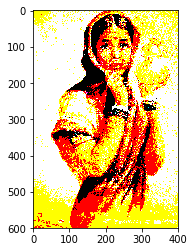

In [10]:
content_image = plt.imread("images/RRV-the-milkmaid.jpg")
content_image = reshape_and_normalize_image(content_image)
plt.imshow(content_image[0])
plt.show()

Let's load, reshape and normalize our "style" image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


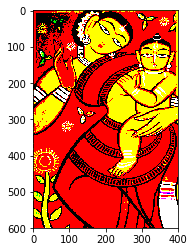

In [11]:
style_image = plt.imread("images/Jamini-Roy-moher-and-son.jpg")
style_image = reshape_and_normalize_image(style_image)
plt.imshow(style_image[0])
plt.show()

Now, we initialize the "generated" image as a noisy image created from the content_image. By initializing the pixels of the generated image to be mostly noise but still slightly correlated with the content image, this will help the content of the "generated" image more rapidly match the content of the "content" image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


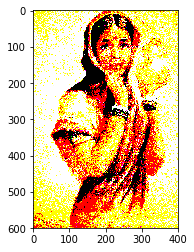

In [12]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0])
plt.show()

To get the program to compute the content cost, we will now assign `a_C` and `a_G` to be the appropriate hidden layer activations. We will use layer `conv4_2` to compute the content cost. The code below does the following:

1. Assign the content image to be the input to the VGG model.
2. Set a_C to be the tensor giving the hidden layer activation for layer "conv4_2".
3. Set a_G to be the tensor giving the hidden layer activation for the same layer. 
4. Compute the content cost using a_C and a_G.

In [13]:
# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

**Note**: At this point, a_G is a tensor and hasn't been evaluated. It will be evaluated and updated at each iteration when we run the Tensorflow graph in model_nst() below.

In [14]:
# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

Compute total cost

In [15]:
J = total_cost(J_content, J_style)

Set optimizer

In [16]:
# define optimizer
optimizer = tf.train.AdamOptimizer(2.0)

# define train_step
train_step = optimizer.minimize(J)

Implement the model_nst() function which initializes the variables of the tensorflow graph, assigns the input image (initial generated image) as the input of the VGG16 model and runs the train_step for a large number of steps.

In [17]:
def model_nst(sess, input_image, num_iterations = 50):
    
    # Initialize global variables
    sess.run(tf.global_variables_initializer())
    
    # Run the noisy input image (initial generated image) through the model
    sess.run(model["input"].assign(input_image))
    
    for i in range(num_iterations):
    
        # Run the session on the train_step to minimize the total cost
        sess.run(train_step)
        
        # Compute the generated image by running the session on the current model['input']
        #generated_image = sess.run(model['input'])

        # Print every n iteration
        if i%50 == 0:
            # Compute the generated image
            generated_image = sess.run(model['input'])
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            #print("content cost = " + str(Jc))
            #print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            save_image("output/" + str(i) + ".png", generated_image)
    
    # save last generated image
    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image.shape

Run the function to generate an artistic image.

In [18]:
model_nst(sess, generated_image, 1000)

Iteration 0 :
total cost = 102396625000.0
Iteration 50 :
total cost = 3001491200.0
Iteration 100 :
total cost = 1067985300.0
Iteration 150 :
total cost = 598819700.0
Iteration 200 :
total cost = 401716600.0
Iteration 250 :
total cost = 298647420.0
Iteration 300 :
total cost = 235869440.0
Iteration 350 :
total cost = 193737730.0
Iteration 400 :
total cost = 163670380.0
Iteration 450 :
total cost = 141418000.0
Iteration 500 :
total cost = 125442030.0
Iteration 550 :
total cost = 115975850.0
Iteration 600 :
total cost = 100813740.0
Iteration 650 :
total cost = 93092010.0
Iteration 700 :
total cost = 85921620.0
Iteration 750 :
total cost = 79065140.0
Iteration 800 :
total cost = 82465310.0
Iteration 850 :
total cost = 80540744.0
Iteration 900 :
total cost = 66688796.0
Iteration 950 :
total cost = 67728200.0


(1, 600, 400, 3)

In [19]:
#writer = tf.summary.FileWriter("output/", sess.graph)

In [20]:
sess.close()

## 3 - Conclusion

That's it, we have a new image now where style of an image is applied on content of another image.

### References:

- Leon A. Gatys, Alexander S. Ecker, Matthias Bethge, (2015). A Neural Algorithm of Artistic Style (https://arxiv.org/abs/1508.06576) 
- Harish Narayanan, Convolutional neural networks for artistic style transfer. https://harishnarayanan.org/writing/artistic-style-transfer/
- Log0, TensorFlow Implementation of "A Neural Algorithm of Artistic Style". http://www.chioka.in/tensorflow-implementation-neural-algorithm-of-artistic-style
- Karen Simonyan and Andrew Zisserman (2015). Very deep convolutional networks for large-scale image recognition (https://arxiv.org/pdf/1409.1556.pdf)
- MatConvNet. http://www.vlfeat.org/matconvnet/pretrained/
- Course on "Convolution Neural Network" by https://www.deeplearning.ai/ on Coursera.